<a href="https://colab.research.google.com/github/MarcioB1999/Aprendizado_de_Maquina/blob/main/Classifica%C3%A7%C3%A3o_Drug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação Bibliotecas**

In [101]:
import pandas as pd
import seaborn as sns
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier as RN
from sklearn.model_selection import cross_val_score, KFold
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn import feature_selection as fs
from yellowbrick.model_selection import ValidationCurve
import warnings
warnings.filterwarnings("ignore")

# **Manipulação e Visualização de Dados**

## **Importação dos Dados**

In [2]:
df = pd.read_csv('drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## **Tratamento**

In [3]:
columns = list(df.columns[1:4])+[df.columns[5]]

print('valores únicos por variável categórica')
for i in columns:
    print(f'{i}----->{df[i].unique()}')

valores únicos por variável categórica
Sex----->['F' 'M']
BP----->['HIGH' 'LOW' 'NORMAL']
Cholesterol----->['HIGH' 'NORMAL']
Drug----->['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']


In [4]:
print('valores faltantes')
df.isnull().sum()

valores faltantes


Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

In [5]:
df.head(3)

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC


In [6]:
columns = list(df.columns[1:4])+[df.columns[5]]

print('valores únicos por variável categórica')
for i in columns:
    print(f'{i}----->{df[i].unique()}')

valores únicos por variável categórica
Sex----->['F' 'M']
BP----->['HIGH' 'LOW' 'NORMAL']
Cholesterol----->['HIGH' 'NORMAL']
Drug----->['DrugY' 'drugC' 'drugX' 'drugA' 'drugB']


In [7]:
columns = ['BP','Cholesterol']
order = {
         'LOW':0,
         'NORMAL':1,
         'HIGH':2
        }

for column in columns:
    df[column] = df[column].map(order)

In [8]:
onehotencoder_census = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(), [1])], remainder='passthrough')
df = pd.DataFrame(onehotencoder_census.fit_transform(df),columns=['Female','Male','Age','BP','Cholesterol','Na_to_K','Drug'])

label_encoder_drug = LabelEncoder()
df['Drug'] = label_encoder_drug.fit_transform(df['Drug'])

df.head()

,Female,Male,Age,BP,Cholesterol,Na_to_K,Drug
0,1.0,0.0,23,2,2,25.355,0
1,0.0,1.0,47,0,2,13.093,3
2,0.0,1.0,47,0,2,10.114,3
3,1.0,0.0,28,1,2,7.798,4
4,1.0,0.0,61,0,2,18.043,0


## **Visualização dos Dados**

In [33]:
def violin_box(df,column,alpha):
    fig=plt.figure(figsize=(4,4))
    ax=fig.add_subplot(1,1,1)

    ax_violin = sns.violinplot(df[column], color="#af52f4", inner=None, linewidth=0, saturation=0.5,ax=ax)
    sns.boxplot(df[column], saturation=0.5, width=0.4, boxprops={'zorder': 2}, ax=ax_violin)

    plt.title(column,fontsize=10)
    plt.ylabel([],fontsize=0)
    plt.grid(axis='y')

    min = df[column].min()
    max = df[column].max()
    mean = round(df[column].mean(),3)
    dp = round(df[column].std(),3)

    alpha=0.08
    dif = max-min

    plt.text(0.5, dif+min, f"Max"+r'$ = $'+f"{max}")
    plt.text(0.5, (1-alpha)*dif+min, f"Min"+r'$ = $'+f"{min}")
    plt.text(0.5, (1-2*alpha)*dif+min, r'$\mu = $'+f"{mean}")
    plt.text(0.5, (1-3*alpha)*dif+min, r'$\sigma = $'+f"{dp}")
    plt.text(0.5, (1-4*alpha)*dif+min, r'$cv = $'+f"{round(dp/mean,3)}")

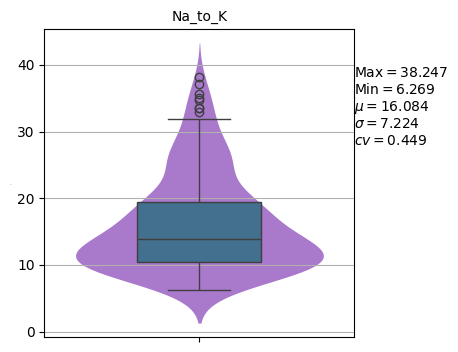

In [34]:
violin_box(df=df,column='Na_to_K',alpha=.07)

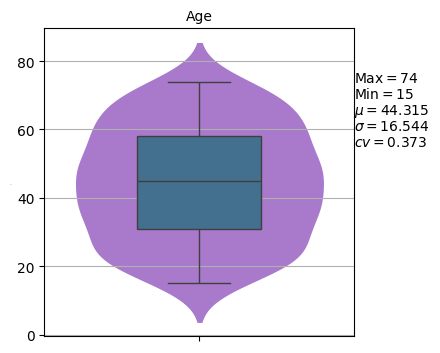

In [35]:
violin_box(df=df,column='Age',alpha=.06)


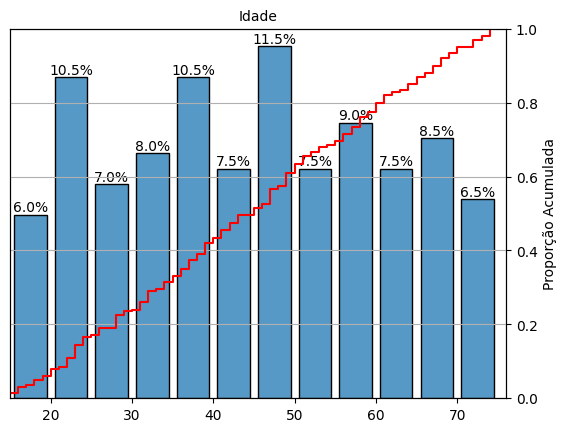

In [40]:
bins=np.arange(15, 80, 5)
ax = sns.histplot(df['Age'], shrink=.8, bins=bins)


freq = pd.cut(df['Age'], bins=np.arange(15, 80, 5),right=False).value_counts(normalize=True).sort_index().values
percent = [f'{"%.1f" % (element*100)}%' for element in freq]

ax.bar_label(ax.containers[0],labels = percent)
plt.xlim(15,76)
plt.title('Idade',fontsize=10)
plt.ylabel('')
plt.xlabel('')
plt.yticks([])

ax2 = ax.twinx()
sns.ecdfplot(data=df, x="Age", stat="proportion",color='red',ax=ax2)
plt.ylabel('Proporção Acumulada')
plt.grid(axis='y')

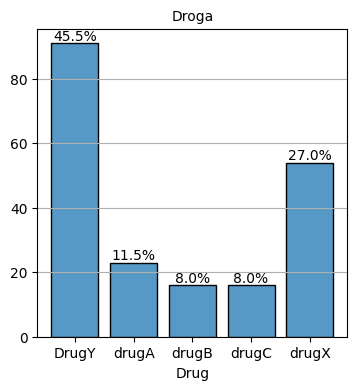

In [12]:
fig=plt.figure(figsize=(4,4))
ax = sns.histplot(df['Drug'],discrete=True, shrink=.8)
freq = df['Drug'].value_counts(normalize=True).sort_index().values
percent = [f'{"%.1f" % (element*100)}%' for element in freq]
ax.bar_label(ax.containers[0],labels = percent)
plt.title('Droga',fontsize=10)
plt.ylabel('')
plt.xticks(ticks=[0,1,2,3,4],labels=['DrugY','drugA', 'drugB', 'drugC','drugX'])
plt.grid(axis='y')


Perceba que os valores da nossa variável alvo são desbalanceados.
Métodos para se lidar
Undersampling - Nesse caso não terá como realizar, pois ja temos poucos dados, e acabaríamos reduzindo muito os dados de modo a estarem com mesma frequência

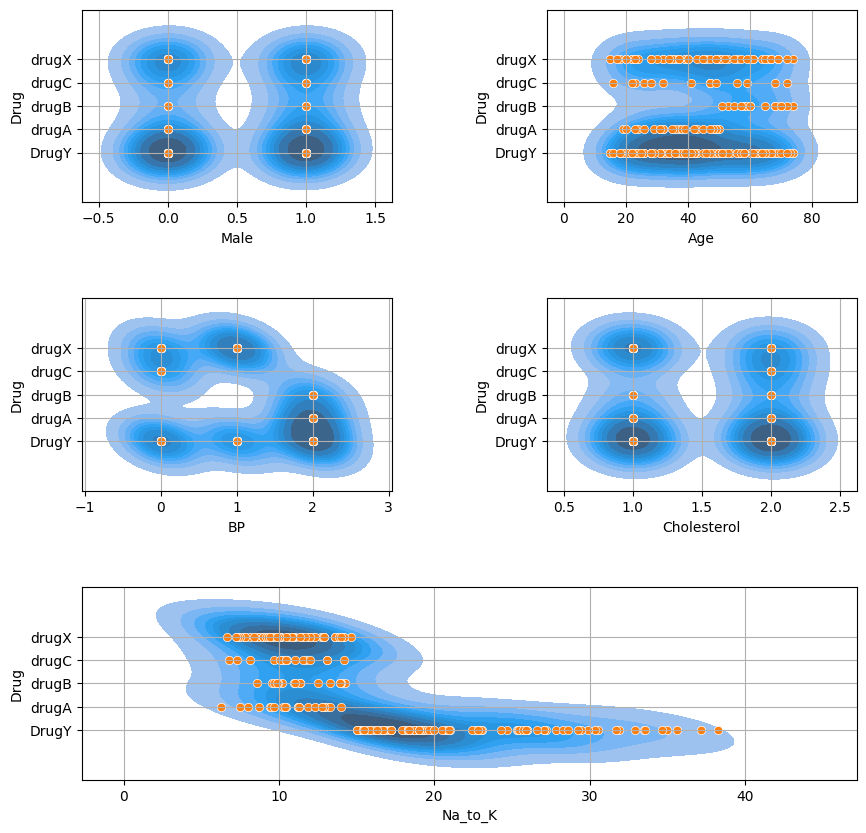

In [13]:
columns = ['Male','Age','BP','Cholesterol']

fig=plt.figure(figsize=(10,10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

indice = 1
for column in columns:
    ax = fig.add_subplot(3,2,indice)
    sns.kdeplot(data=df, x=column, y="Drug", fill=True)
    sns.scatterplot(data=df, x=column, y="Drug")
    plt.yticks(ticks=[0,1,2,3,4],labels=['DrugY','drugA', 'drugB', 'drugC','drugX'])
    plt.grid(axis='both')

    indice = indice+1

ax = fig.add_subplot(3,1,3)
sns.kdeplot(data=df, x='Na_to_K', y="Drug", fill=True)
sns.scatterplot(data=df, x='Na_to_K', y='Drug')
plt.yticks(ticks=[0,1,2,3,4],labels=['DrugY','drugA', 'drugB', 'drugC','drugX'])
plt.grid(axis='both')
    

Perceba que nenhuma relação muito forte individualmente com Drug, o mais perto que temos inicialmente é a variável Na_to_K, que a partir do valor 15 temos apenas presença da drogaY.

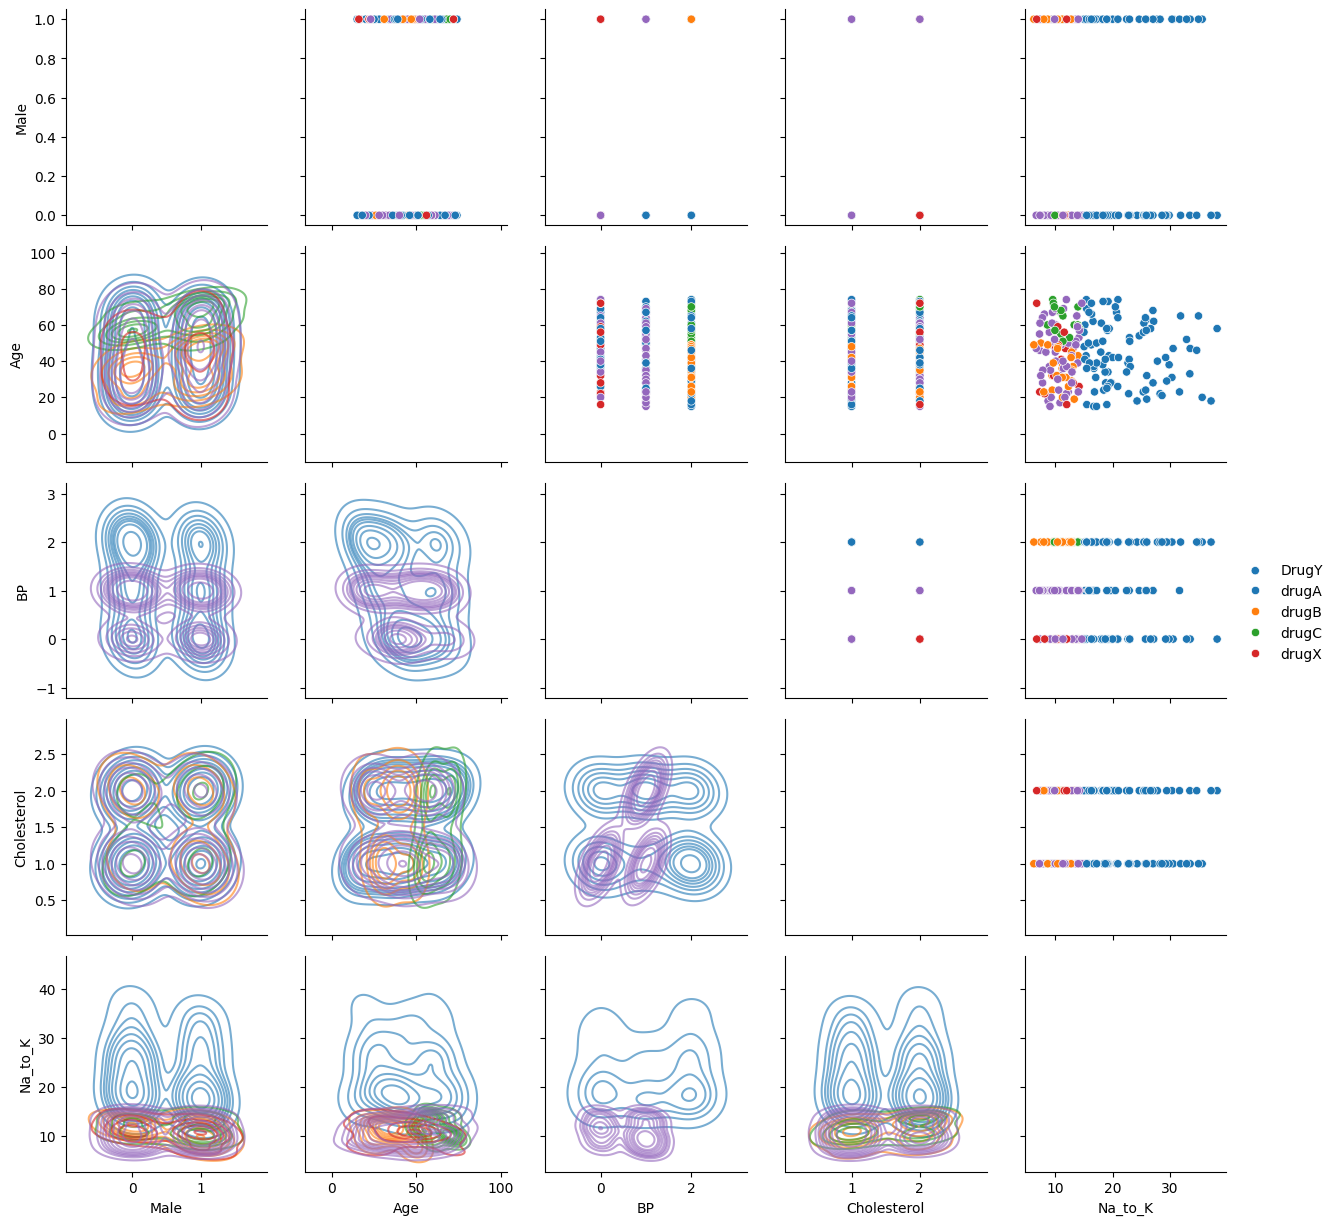

In [37]:
g = sns.PairGrid(df.drop('Female',axis=1), hue='Drug', palette=sns.color_palette("tab10"))

g.map_lower(sns.kdeplot, warn_singular=False, alpha=.6)
g.map_upper(sns.scatterplot)
g.add_legend(title="", adjust_subtitles=True, labels=['DrugY','drugA', 'drugB', 'drugC','drugX'])

Inicialmente podemos olhar para a variável Na_to_K que sabemos que ela faz uma divisão perfeita entre uma das drogas e das demais. Analisando podemos notar que a melhor combinação de Na_to_K com outras variáveis é com BP. Percebe-se que abaixo do valor 15 de Na_to_k, no qual anteriormente não tinhamos uma divisão entre as drogas, agora temos uma divisão que visiualmente parece boa. Infelizmente não se nota nenhuma outra boa combinação entre qualquer outras duas variáveis. Importante frizar que nenhuma variável não alvo não possui nenhum tipo de relação com outra variável não alvo.

In [ ]:
freq = df[df['Na_to_K']<15].groupby('BP').Drug.value_counts(normalize=True)
freq

BP  Drug
0   4       0.529412
    3       0.470588
1   4       1.000000
2   1       0.589744
    2       0.410256
Name: proportion, dtype: float64

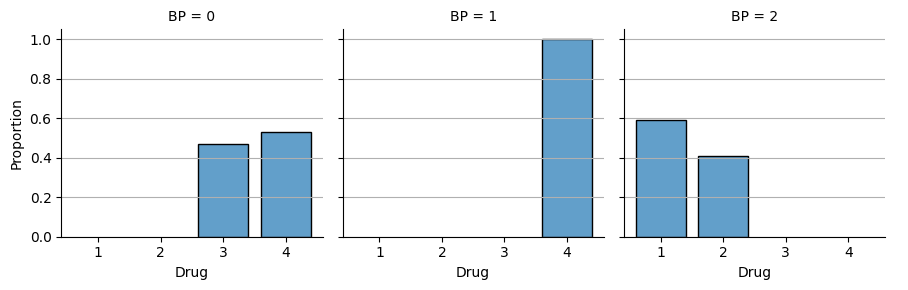

In [40]:
g = sns.FacetGrid(df[df['Na_to_K']<15], col="BP")
g.map(sns.histplot,'Drug', alpha=.7,discrete=True, shrink=.8,stat='proportion')
g.map_dataframe(lambda **kws: plt.grid(axis='y'))
g.add_legend()

Olhando de maneira mais detalhada para a proporção das drogas para cada valor de BP, percemos que a droga X tem uma boa divisão. Pois para BP=1 temos apenas sua presença, entretanto ainda se tem sua presença para o valor de BP=0. E infelizmente a variável droga possui uma distribuição condicional, quando BP=0, bem uniforme para as drogas C e X

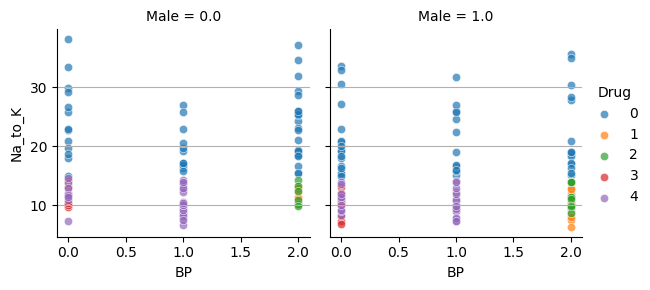

In [42]:
g = sns.FacetGrid(df, col="Male", hue="Drug")
g.map(sns.scatterplot, "BP", "Na_to_K", alpha=.7)
g.map_dataframe(lambda **kws: plt.grid(axis='y'))
g.add_legend()

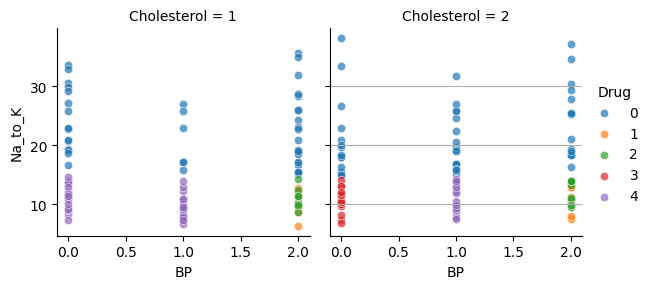

In [44]:
g = sns.FacetGrid(df, col="Cholesterol", hue="Drug")

g.map_dataframe(lambda **kws: plt.grid(axis='y'))
g.map(sns.scatterplot, "BP", "Na_to_K", alpha=.7)
g.add_legend()

Note que diferente da variável Male, temos que visualmente obtemos uma divisão boa dos dados quando temos BP=1, dividindo eles em roxa quando Cholesterol=1, e vermelhas para caso contrário.

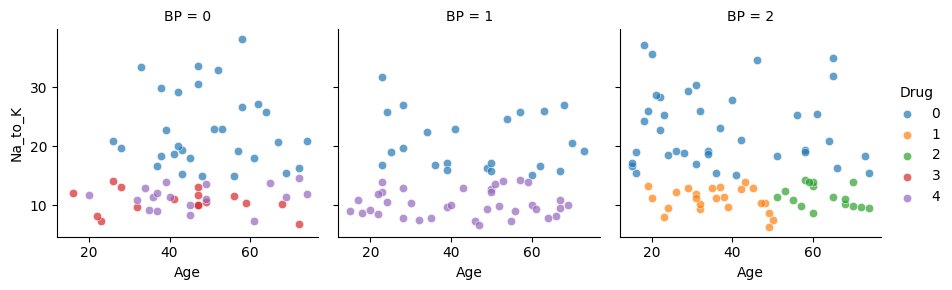

In [ ]:
g = sns.FacetGrid(df, col="BP", hue="Drug")
g.map(sns.scatterplot, "Age", "Na_to_K", alpha=.7)
g.add_legend()

Igualmente Age tambem faz uma boa divisão dos dados quando BP=2

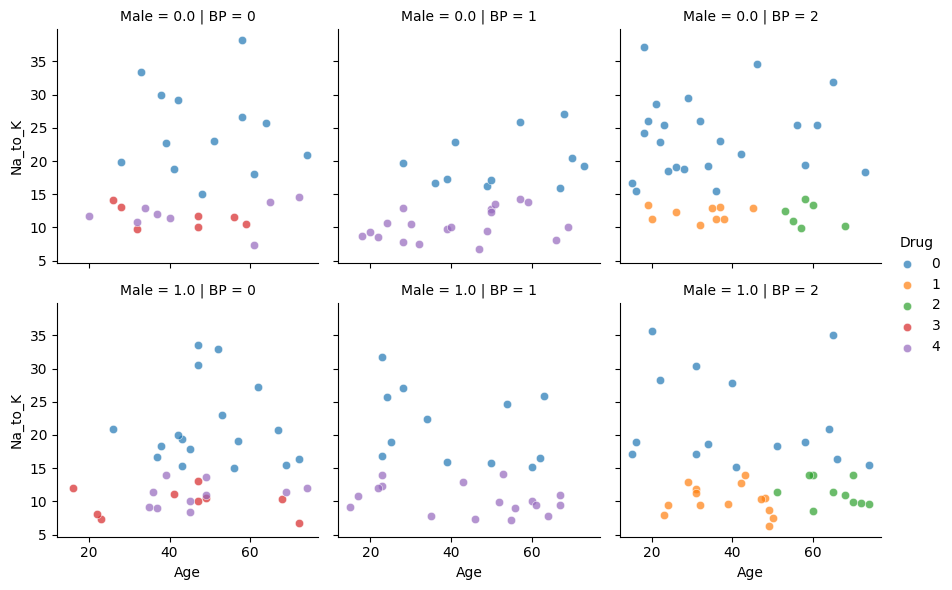

In [ ]:
g = sns.FacetGrid(df, col="BP", row='Male', hue="Drug")
g.map(sns.scatterplot, "Age", "Na_to_K", alpha=.7)
g.add_legend()

Perceba que novamente a variável Male não foi capaz de separar de alguma forma os dados como ja esperado por gráficos anteriores. Contudo, vimos anteriormente que quem faz uma boa divisão quando se tem BP=1 é a variável Cholesterol.Pode-se confirmar isso ao ver o próximo gráfico.

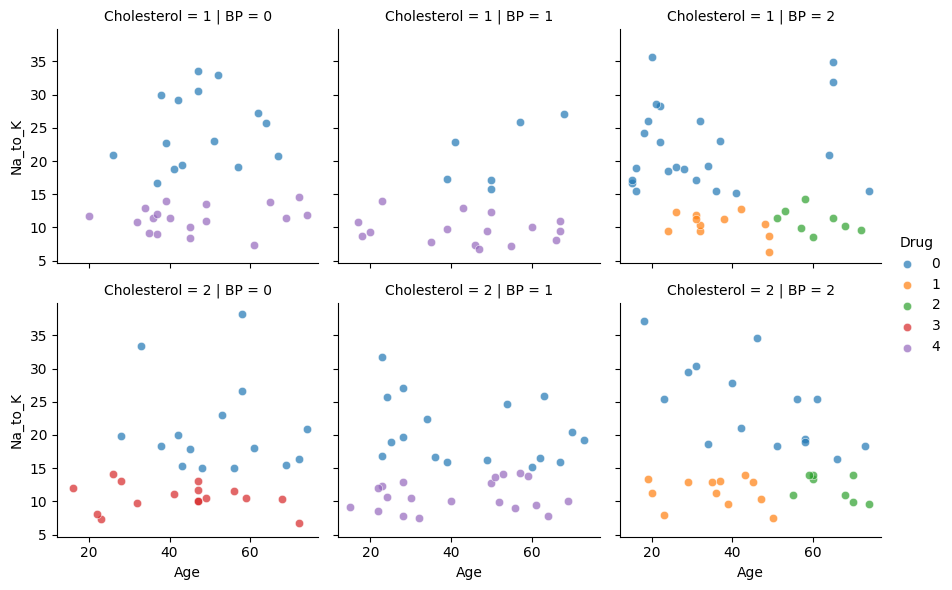

In [ ]:
g = sns.FacetGrid(df, col="BP", row='Cholesterol', hue="Drug")
g.map(sns.scatterplot, "Age", "Na_to_K", alpha=.7)
g.add_legend()

In [58]:
x = df.drop(['Drug'],axis=1).values
y = df['Drug'].values
mi = fs.mutual_info_classif(x,y)

In [59]:

mi = pd.Series(mi)
mi.index =df.drop(['Drug'],axis=1).columns
mi.sort_values(ascending=False,inplace=True)

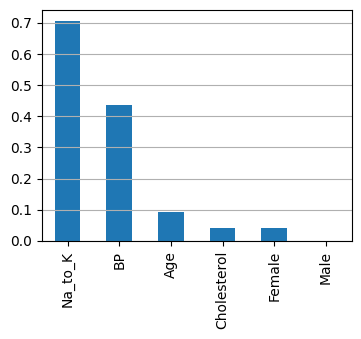

In [64]:
plt.figure(figsize=(4,3))
mi.plot.bar()
plt.grid(axis='y')

Portanto além de considerar as duas de maior pontuação, iremos pegar também a Age e Cholesterol

## **Transformação**

In [75]:
X = df[['Na_to_K','BP','Age','Cholesterol']]
Y = df['Drug']

In [76]:
X_scaled = pd.DataFrame({})
min_max_scale = dict({})

In [77]:
for column in ['Na_to_K','Age']:

    min_max_scale[column] = MinMaxScaler()
    scaled = min_max_scale[column].fit_transform(df[column].values.reshape(-1, 1))
    X_scaled[column] = scaled.reshape(-1)

X_scaled['BP'] = X['BP']
X_scaled['Cholesterol'] = X['Cholesterol']


In [78]:
X_scaled.head()

,Na_to_K,Age,BP,Cholesterol
0,0.596848,0.135593,2,2
1,0.213397,0.542373,0,2
2,0.120239,0.542373,0,2
3,0.047814,0.220339,1,2
4,0.368191,0.779661,0,2


# **Pegando Melhores Parâmetros para Cada Modelo**
SVM, Random Forest, Rede Neural

## **redes neurais**

In [79]:
parametros = {'activation': ['relu', 'logistic', 'tahn'],
              'solver': ['adam', 'sgd'],
              'batch_size': [10, 56]}

In [81]:
grid_search = GridSearchCV(estimator=RN(), param_grid=parametros)
grid_search.fit(X_scaled, Y)
melhores_parametros_RN = grid_search.best_params_

In [82]:
print(melhores_parametros_RN)

{'activation': 'relu', 'batch_size': 10, 'solver': 'adam'}


## **SVM**

In [83]:
parametros = {'tol': [0.001, 0.0001, 0.00001],
              'C': [1.0, 1.5, 2.0],
              'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}

In [84]:
grid_search = GridSearchCV(estimator=SVC(), param_grid=parametros)
grid_search.fit(X_scaled, Y)
melhores_parametros_SVM = grid_search.best_params_


In [85]:
print(melhores_parametros_SVM)

{'C': 2.0, 'kernel': 'poly', 'tol': 0.001}


##**Random Forest**

In [86]:
parametros = {'criterion': ['gini', 'entropy'],
              'n_estimators': [10, 40, 100, 150],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 5, 10]}

In [87]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parametros)
grid_search.fit(X_scaled, Y)
melhores_parametros_RF = grid_search.best_params_


In [88]:
print(melhores_parametros_RF)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# **Comparação de Modelos**
SVM, Random Forest, Rede Neural

In [89]:
resultados_rede_neural = []
resultados_random_forest = []
resultados_svm = []


for i in range(60):

    kfold = KFold(n_splits=10, shuffle=True, random_state=i)


    random_forest = RandomForestClassifier(
              criterion = melhores_parametros_RF['criterion'],
              n_estimators = melhores_parametros_RF['n_estimators'],
              min_samples_split = melhores_parametros_RF['min_samples_split'],
              min_samples_leaf = melhores_parametros_RF['min_samples_leaf']
              )
    scores = cross_val_score(random_forest, X_scaled, Y, cv = kfold)
    resultados_random_forest.append(scores.mean())


    svm = SVC(
            tol = melhores_parametros_SVM['tol'],
            C = melhores_parametros_SVM['C'],
            kernel = melhores_parametros_SVM['kernel']
            )
    scores = cross_val_score(svm, X_scaled, Y, cv = kfold)
    resultados_svm.append(scores.mean())


    rede_neural = RN(
              activation = melhores_parametros_RN['activation'],
              solver = melhores_parametros_RN['solver'],
              batch_size = melhores_parametros_RN['batch_size']
               )
    scores = cross_val_score(rede_neural, X_scaled, Y, cv = kfold)
    resultados_rede_neural.append(scores.mean())


In [90]:
resultados = pd.DataFrame({'Random forest': resultados_random_forest,
                           'SVM': resultados_svm,
                           'Rede neural': resultados_rede_neural})
resultados.head(5)

,Random forest,SVM,Rede neural
0,0.990,0.950,0.980
1,0.985,0.965,0.975
2,0.990,0.950,0.985
3,0.990,0.945,0.980
4,0.990,0.950,0.975


In [91]:
resultados.describe()

,Random forest,SVM,Rede neural
count,60.000000,60.000000,60.00000
mean,0.989417,0.958583,0.97850
std,0.001862,0.008442,0.00463
min,0.985000,0.935000,0.96500
25%,0.990000,0.955000,0.97500
50%,0.990000,0.960000,0.98000
75%,0.990000,0.965000,0.98000
max,0.995000,0.975000,0.99000


In [92]:
print('Coeficiente de Variação')
(resultados.std() / resultados.mean()) * 100

Coeficiente de Variação


Random forest    0.188204
SVM              0.880655
Rede neural      0.473215
dtype: float64

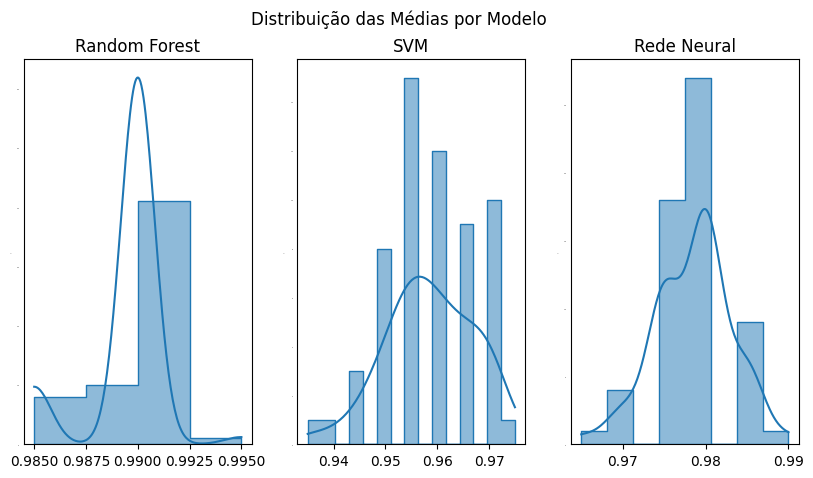

In [93]:
fig=plt.figure(figsize=(10,5))
fig.suptitle('Distribuição das Médias por Modelo')


ax = fig.add_subplot(1,3,1)
ax.set_title('Random Forest')
sns.histplot(resultados_random_forest, bins=len(pd.Series(resultados_random_forest).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

ax = fig.add_subplot(1,3,2)
ax.set_title('SVM')
sns.histplot(resultados_svm, bins=len(pd.Series(resultados_svm).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

ax = fig.add_subplot(1,3,3)
ax.set_title('Rede Neural')
sns.histplot(resultados_rede_neural, bins=len(pd.Series(resultados_rede_neural).unique()), kde=True, element='step')
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)

In [94]:
alpha=0.05

In [95]:
p={}
_,p['Random Forest'] = shapiro(resultados_random_forest)
_,p['SVM'] = shapiro(resultados_svm)
_,p['Rede Neural'] = shapiro(resultados_rede_neural)
for i in p:
    if p[i] <= alpha:
        print(f'Média amostral de {i} não segue uma normal')
    else:
        print(f'Média amostral de {i} segue uma normal')

Média amostral de Random Forest não segue uma normal
Média amostral de SVM não segue uma normal
Média amostral de Rede Neural não segue uma normal


In [96]:
classificador_rede_neural = RN(
              activation = melhores_parametros_RN['activation'],
              solver = melhores_parametros_RN['solver'],
              batch_size = melhores_parametros_RN['batch_size']
              )
classificador_rede_neural.fit(X_scaled, Y)



classificador_svm = SVC(
            tol = melhores_parametros_SVM['tol'],
            C = melhores_parametros_SVM['C'],
            kernel = melhores_parametros_SVM['kernel']
            )
classificador_svm.fit(X_scaled, Y)



classificador_random_forest = RandomForestClassifier(
              criterion = melhores_parametros_RF['criterion'],
              n_estimators = melhores_parametros_RF['n_estimators'],
              min_samples_split = melhores_parametros_RF['min_samples_split'],
              min_samples_leaf = melhores_parametros_RF['min_samples_leaf']
              )

classificador_random_forest.fit(X_scaled, Y)

RandomForestClassifier()

# **Matriz de confusão**

Text(0.5, 0, 'Valor Predito')

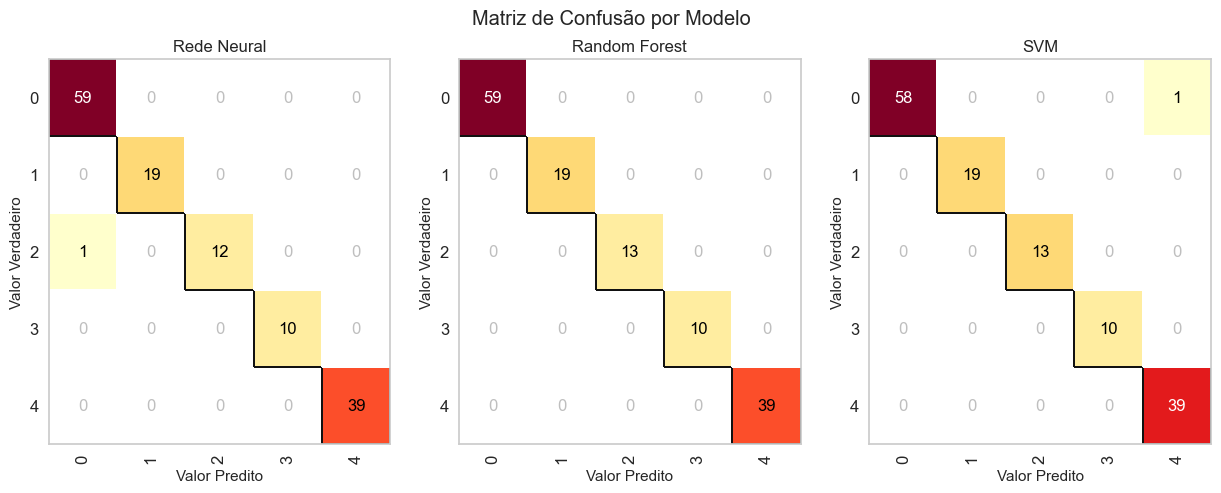

In [100]:
fig=plt.figure(figsize=(15,5))
fig.suptitle('Matriz de Confusão por Modelo')
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, Y, test_size=0.7, random_state=42
    )


ax = fig.add_subplot(1,3,1)
ax.set_title('Rede Neural')

cm=ConfusionMatrix(classificador_rede_neural)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')


ax = fig.add_subplot(1,3,2)
ax.set_title('Random Forest')
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, Y, test_size=0.7, random_state=42
    )
cm=ConfusionMatrix(classificador_random_forest)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')


ax = fig.add_subplot(1,3,3)
ax.set_title('SVM')
X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, Y, test_size=0.7, random_state=42
    )
cm=ConfusionMatrix(classificador_svm)
cm.fit(X_train,y_train)
cm.score(X_test,y_test)
plt.ylabel('Valor Verdadeiro')
plt.xlabel('Valor Predito')

# **Exportando Modelos**

In [ ]:
pickle.dump(classificador_rede_neural, open('rede_neural_finalizado.sav', 'wb'))

pickle.dump(classificador_svm, open('svm_finalizado.sav', 'wb'))

pickle.dump(classificador_random_forest, open('random_forest_finalizado.sav', 'wb'))